<a href="https://colab.research.google.com/github/Simon-creator-jara/Inteligencia_artificial/blob/main/DL_ClasificacionCancerPulmon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferencia de conocimiento

Existen varias redes ya entrenadas para otros casos que pueden ser reusadas para clasificación, reusando los pesos ya entrenados de algunas de sus capas. Específicamente de las capas que se encargan de extraer rasgos importantes de los objetos.

## Datos de cáncer de pulmón
Se van a usar algunas imágenes para poder hacer la clasificación en subtipos de carcinomas pulmonares de células no-pequeñas:


*   **Adenocarcinoma**
*   Carcinoma pulmonar de células grandes (**large cell carcinoma**)
*   Carcinoma espinocelular (**squamous cell carcinoma**)

Y además hay algunas imágenes sin cáncer (**Normal**)



In [ ]:
!unzip '/content/drive/MyDrive/HealthData/CancerPulmon.zip'

Archive:  /content/drive/MyDrive/HealthData/CancerPulmon.zip
   creating: CancerPulmon/
   creating: CancerPulmon/test/
   creating: CancerPulmon/test/adenocarcinoma/
  inflating: CancerPulmon/test/adenocarcinoma/000108 (3).png  
  inflating: CancerPulmon/test/adenocarcinoma/000109 (2).png  
  inflating: CancerPulmon/test/adenocarcinoma/000109 (4).png  
  inflating: CancerPulmon/test/adenocarcinoma/000109 (5).png  
  inflating: CancerPulmon/test/adenocarcinoma/000112 (2).png  
  inflating: CancerPulmon/test/adenocarcinoma/000113 (7).png  
  inflating: CancerPulmon/test/adenocarcinoma/000114 (5).png  
  inflating: CancerPulmon/test/adenocarcinoma/000114.png  
  inflating: CancerPulmon/test/adenocarcinoma/000115 (4).png  
  inflating: CancerPulmon/test/adenocarcinoma/000115 (8).png  
  inflating: CancerPulmon/test/adenocarcinoma/000115.png  
  inflating: CancerPulmon/test/adenocarcinoma/000116 (5).png  
  inflating: CancerPulmon/test/adenocarcinoma/000116 (7).png  
  inflating: CancerPul

In [ ]:
import glob

In [ ]:
adenocarcinoma = glob.glob("/content/CancerPulmon/train/adenocarcinoma/*.png")
normal= glob.glob("/content/CancerPulmon/train/normal/*.png")
large_cell=glob.glob("/content/CancerPulmon/train/large.cell.carcinoma/*.png")
squamous_cell=glob.glob("/content/CancerPulmon/train/squamous.cell.carcinoma/*.png")

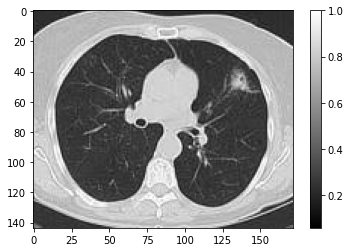

In [ ]:
img = plt.imread(adenocarcinoma[0])
plt.gray()
plt.imshow(img)
plt.grid(False)
plt.colorbar()

In [ ]:
img.shape

(144, 172, 4)

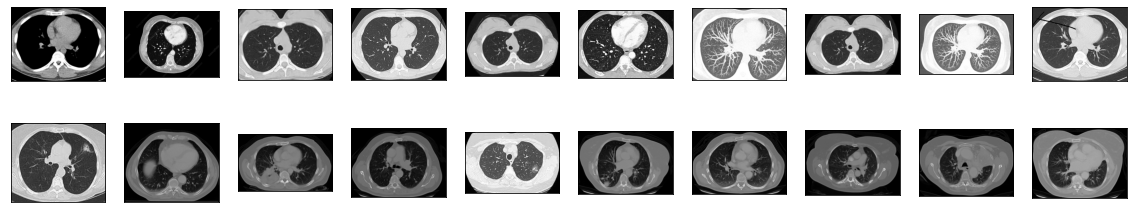

In [ ]:
plt.figure(figsize=(20, 4))
for i, (im1, im2) in enumerate(zip(normal[0:10], adenocarcinoma[0:10])):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(plt.imread(im1))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 + 10)
  plt.imshow(plt.imread(im2))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

## Cargar los datos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
batch_size=64
train_it = datagen.flow_from_directory('/content/CancerPulmon/train', class_mode='categorical', batch_size=batch_size, target_size=(224, 224))
test_it = datagen.flow_from_directory('/content/CancerPulmon/test', class_mode='categorical', batch_size=batch_size, target_size=(224, 224), shuffle=False)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


## VGG-16

La base de datos VGG16 es una red que se utiliza mucho en clasificación, haciendo transferencia de conocimiento, ha msotrado tener buen poder de extración de rasgos.

Fue entrenada para clasificar 1000 objetos diferentes y utiliza una entrada de 224x224 con canal RGB.

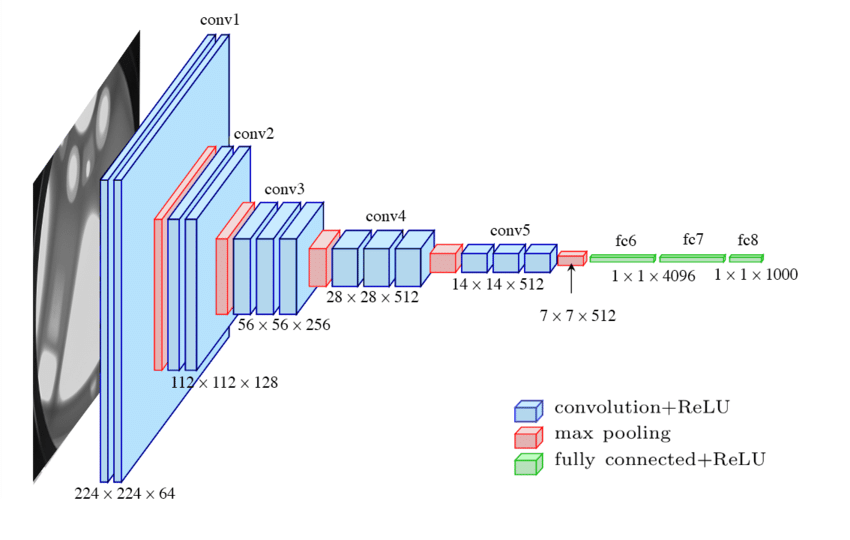
Tomada de: https://www.researchgate.net/publication/322512435_Automatic_localization_of_casting_defects_with_convolutional_neural_networks


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D,MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.utils import plot_model

In [ ]:
model = VGG16()

553476096/553467096 [==============================] - 5s 0us/step


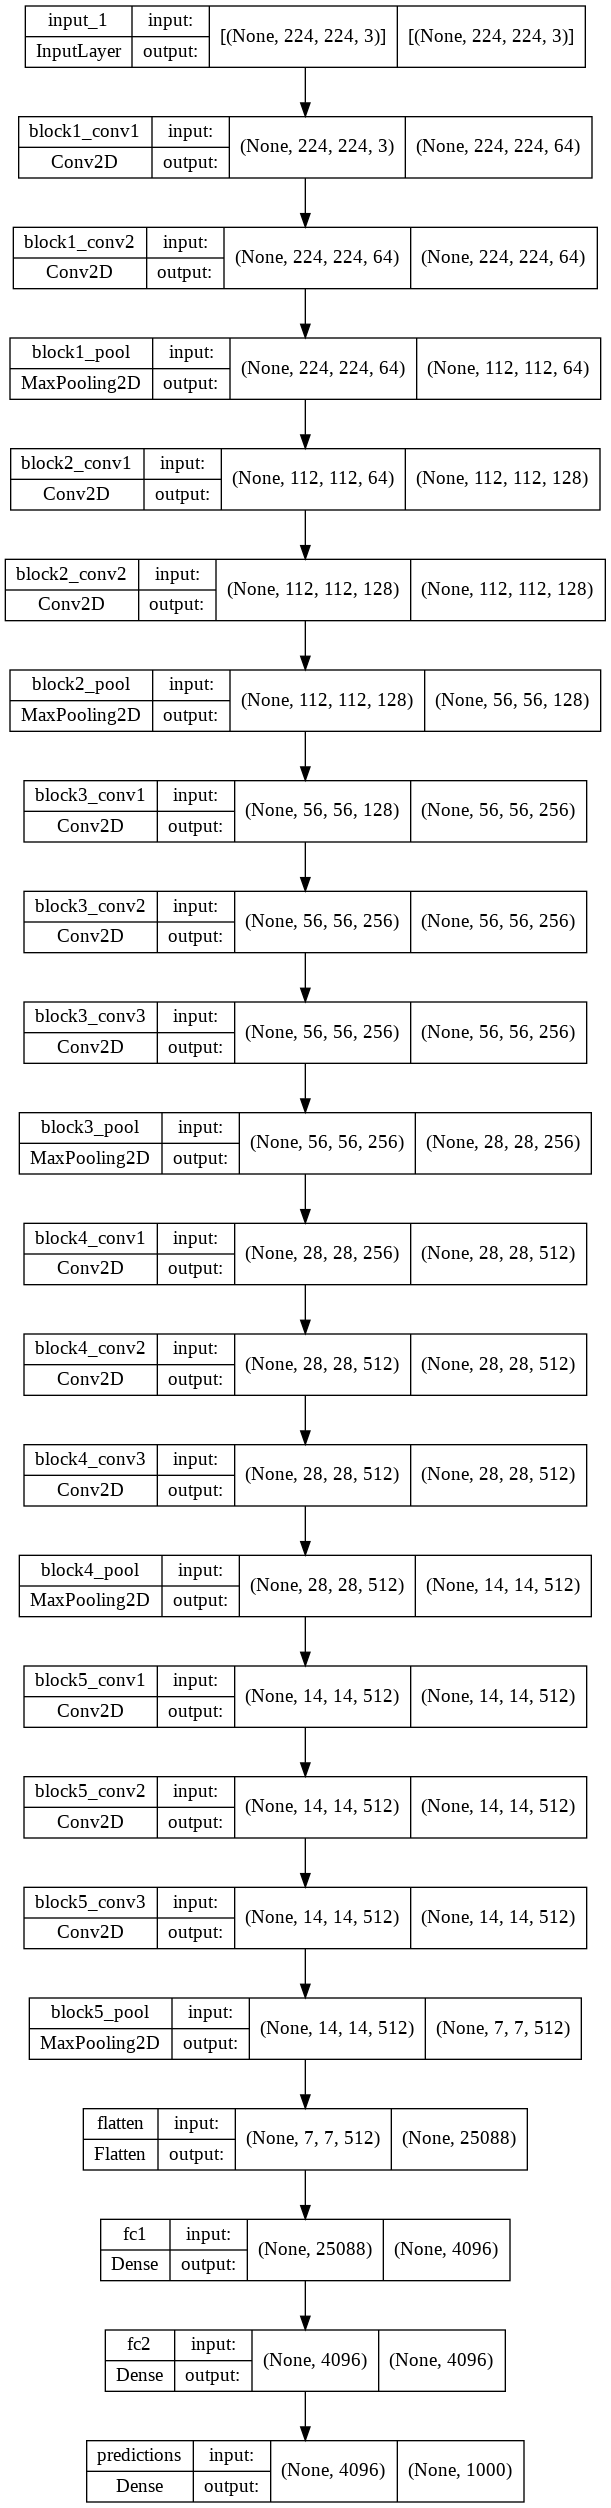

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
modelWT = VGG16(include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 0s 0us/step


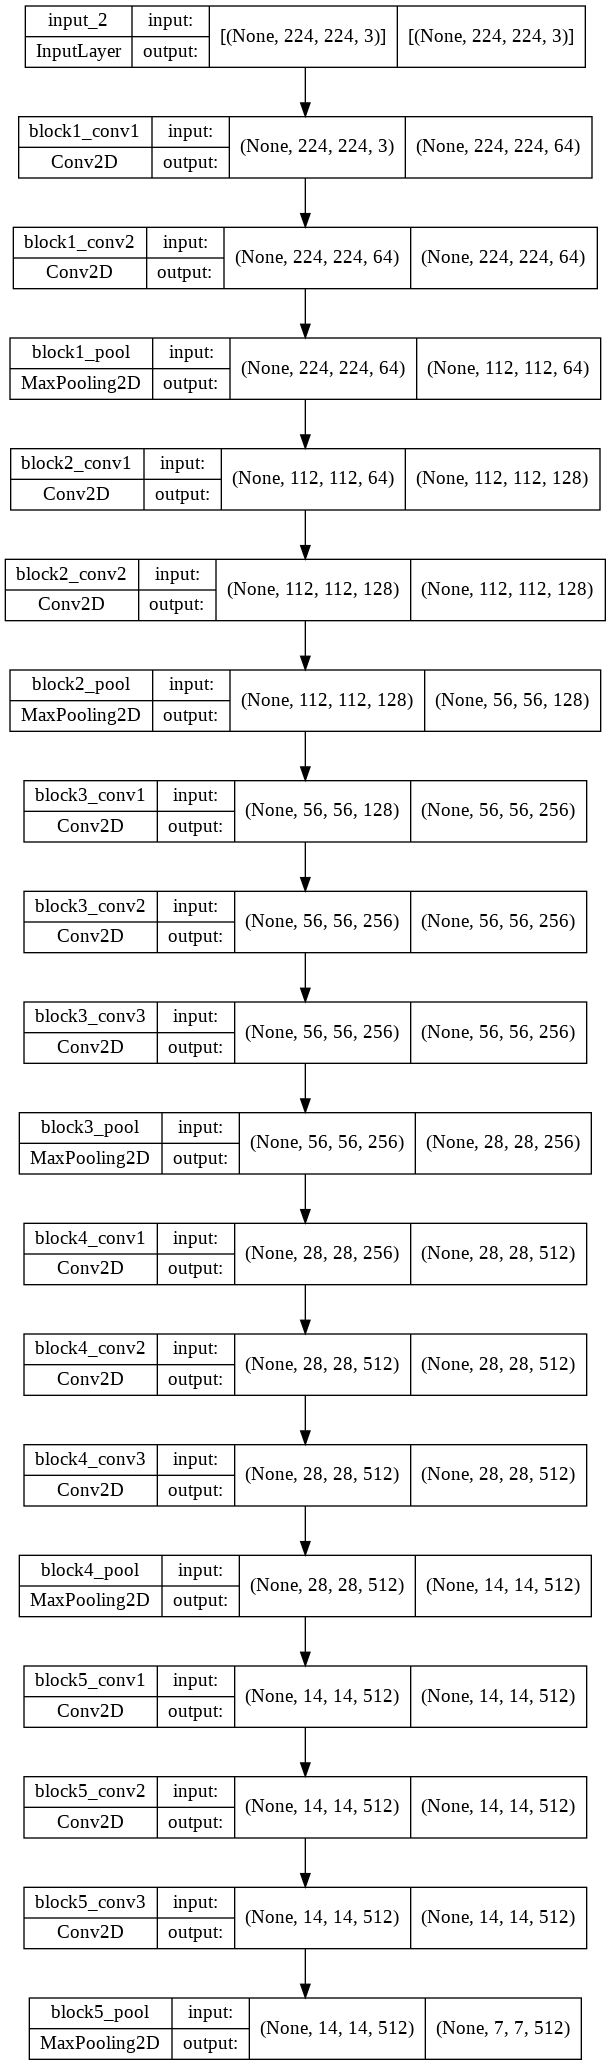

In [ ]:
plot_model(modelWT,show_shapes=True)

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
modelWT.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_VGG16 = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in model_VGG16.layers:
  layer.trainable = False
x = Flatten()(model_VGG16.output)
x = Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(4, activation='softmax')(x)

model_VGG16 = Model(inputs=model_VGG16.inputs, outputs=output)

opt = SGD(learning_rate=0.001, momentum=0.9)
model_VGG16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_it,validation_data=test_it,epochs=20)

Epoch 1/20
10/10 [==============================] - 32s 2s/step - loss: 1.3842 - accuracy: 0.3638 - val_loss: 1.2218 - val_accuracy: 0.4476
Epoch 2/20
10/10 [==============================] - 9s 864ms/step - loss: 1.0803 - accuracy: 0.5498 - val_loss: 1.0697 - val_accuracy: 0.4794
Epoch 3/20
10/10 [==============================] - 9s 851ms/step - loss: 0.9519 - accuracy: 0.6183 - val_loss: 1.1686 - val_accuracy: 0.4349
Epoch 4/20
10/10 [==============================] - 9s 856ms/step - loss: 0.8975 - accuracy: 0.6248 - val_loss: 0.9776 - val_accuracy: 0.5524
Epoch 5/20
10/10 [==============================] - 9s 860ms/step - loss: 0.8470 - accuracy: 0.6395 - val_loss: 0.9461 - val_accuracy: 0.5778
Epoch 6/20
10/10 [==============================] - 9s 862ms/step - loss: 0.7849 - accuracy: 0.6607 - val_loss: 0.9127 - val_accuracy: 0.5873
Epoch 7/20
10/10 [==============================] - 9s 854ms/step - loss: 0.7433 - accuracy: 0.6656 - val_loss: 0.9212 - val_accuracy: 0.5873
Epoch 8/

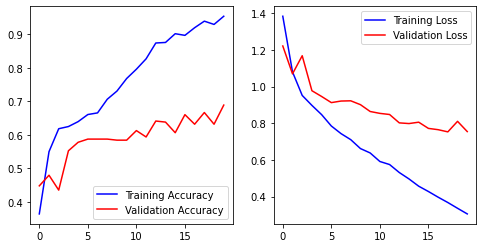

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
model_VGG16 = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in model_VGG16.layers:
  layer.trainable = False
x = Flatten()(model_VGG16.output)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)

model_VGG16 = Model(inputs=model_VGG16.inputs, outputs=output)
model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_it,validation_data=test_it,epochs=20)

Epoch 1/20
10/10 [==============================] - 9s 902ms/step - loss: 0.3576 - accuracy: 0.8108 - val_loss: 0.6653 - val_accuracy: 0.7587
Epoch 2/20
10/10 [==============================] - 9s 854ms/step - loss: 0.4134 - accuracy: 0.7732 - val_loss: 0.6094 - val_accuracy: 0.8000
Epoch 3/20
10/10 [==============================] - 9s 858ms/step - loss: 0.3722 - accuracy: 0.8075 - val_loss: 0.5714 - val_accuracy: 0.8317
Epoch 4/20
10/10 [==============================] - 9s 858ms/step - loss: 0.3803 - accuracy: 0.7993 - val_loss: 0.5925 - val_accuracy: 0.7937
Epoch 5/20
10/10 [==============================] - 8s 872ms/step - loss: 0.3357 - accuracy: 0.8401 - val_loss: 0.5710 - val_accuracy: 0.8254
Epoch 6/20
10/10 [==============================] - 8s 882ms/step - loss: 0.3744 - accuracy: 0.8075 - val_loss: 0.6231 - val_accuracy: 0.7746
Epoch 7/20
10/10 [==============================] - 8s 875ms/step - loss: 0.3520 - accuracy: 0.8254 - val_loss: 0.7105 - val_accuracy: 0.7111
Epoch 

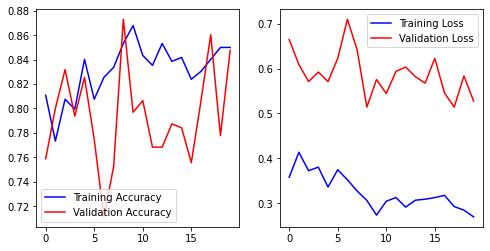

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epoch=range(len(acc))
loss=history.history['loss']
val_loss=history.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [ ]:
def plot_history(history):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  epoch=range(len(acc))
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  f,ax=plt.subplots(1,2,figsize=(8,4))
  ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
  ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
  ax[0].legend()
  ax[1].plot(epoch,loss,'blue',label='Training Loss')
  ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
  ax[1].legend()
  plt.show()

In [ ]:
l,a=model.evaluate(test_it)

5/5 [==============================] - 3s 578ms/step - loss: 0.5277 - accuracy: 0.8476


In [ ]:
tp=model.predict(test_it)

In [ ]:
y_predicted=np.argmax(tp, axis=1)
y_predicted

array([0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 1, 0, 1, 0,
       0, 3, 0, 1, 3, 3, 3, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3,

In [ ]:
test_it.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
test_it.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [ ]:
class_names=[k for k in test_it.class_indices.keys()]

In [ ]:
cm=confusion_matrix(test_it.classes,y_predicted)
cm

array([[85, 14,  2, 19],
       [ 2, 48,  0,  1],
       [ 0,  1, 53,  0],
       [ 4,  5,  0, 81]])

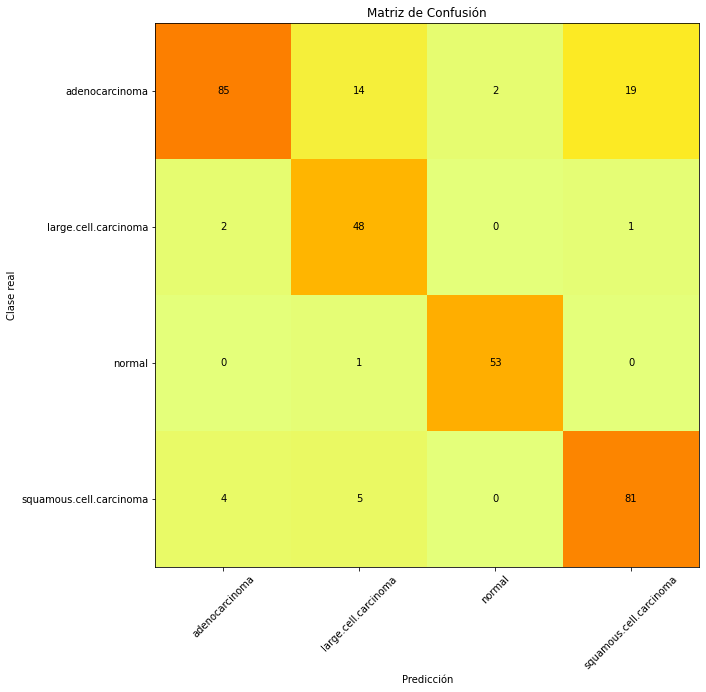

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = class_names
plt.title('Matriz de Confusión')
plt.ylabel('Clase real')
plt.xlabel('Predicción')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i, str(cm[i][j]),ha="center", va="center")
        plt.rcParams["axes.grid"] = False
plt.show()

In [ ]:
def plot_confusionMatrix(y, y_predicted,class_names):
  cm=confusion_matrix(y,y_predicted)
  plt.figure(figsize=(10,10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = class_names
  plt.title('Matriz de Confusión')
  plt.ylabel('Clase real')
  plt.xlabel('Predicción')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          plt.text(j,i, str(cm[i][j]),ha="center", va="center")
          plt.rcParams["axes.grid"] = False
  plt.show()

## VGG-19
Esta es otra red que surge como una variación de la anterior, también entrenada con entradas de 224x224 e imágenes RGB

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

## Ejercicio 1
**Haga un modelo, usando la red VGG-19 y transferencia de conocmiento, para entrenar los mismos datos.**

## Inception V3

Esta es otra red entrenada con entradas de 299x299 e imágenes RGB.

Para ejecutar esta debe volver a cargar las imágenes, ahora con este tamaño, o si las imágenes son más pequeñas tmabién se podría poner el input de la red más pequeño.

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
model_Inception = InceptionV3(include_top=False, input_shape=(299, 299, 3))
model_Inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

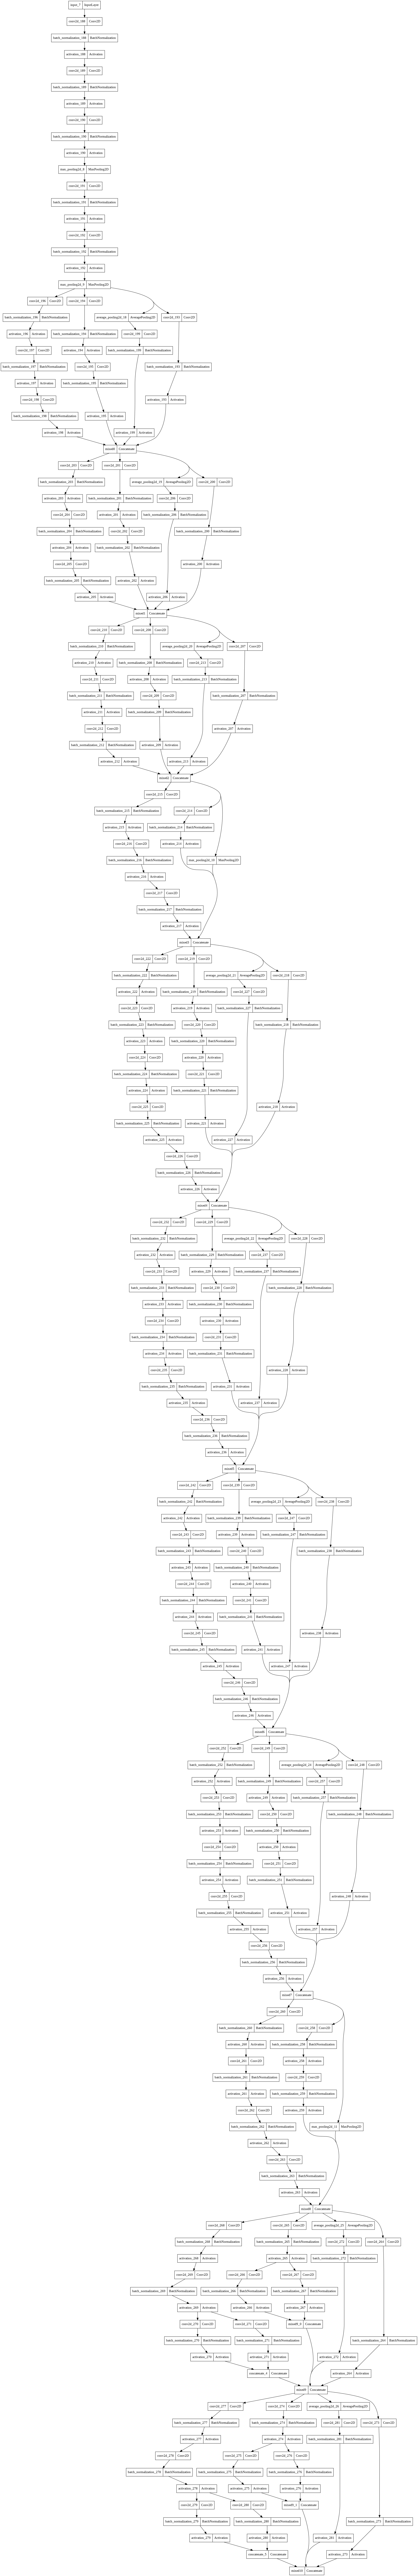

In [ ]:
plot_model(model_Inception)

## Ejercicio 2
**Cargue los datos, cree el modelo y entrénelo**

## Transferencia de conocimiento con otros clasificadores

Otra de las formas de hacer transferencia de conocimiento es utilizando la extracción de rasgos de algunos de estos modelos entrenados, como en el caso anterior, pero en vez de utilizar capas al final, utilizar esto como entrada a otros clasificadores. O sea, la extracción de rasgos del modelo de deep learning (cualqueira de los modelos vistos anteriormente), nos da una represetación vectorial de la imagen que puede servir de entrada a cualquier clasificador de los vistos en machine learning, como: árboles, KNN, SVM e incluso redes neuronales.

Vamos a utilizar por ejemplo Inception con KNN para ver un ejemplo del mismo.

In [ ]:
model_Inception = InceptionV3(include_top=False, input_shape=(299, 299, 3))
output = Flatten()(model_Inception.output)

model_Inception = Model(inputs=model_Inception.inputs, outputs=output)

In [ ]:
model_Inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

**Importante**: para cargar los datos debemos poner shuffle=False para que no aleatorice los datos y podamos tomar las etiquetas correspondientes.

In [ ]:
batch_size=64
train_it = datagen.flow_from_directory('/content/CancerPulmon/train', class_mode='categorical', batch_size=batch_size, target_size=(299, 299), shuffle=False)
test_it = datagen.flow_from_directory('/content/CancerPulmon/test', class_mode='categorical', batch_size=batch_size, target_size=(299, 299), shuffle=False)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
X_train=model_Inception.predict(train_it)

In [ ]:
X_train.shape

(613, 131072)

In [ ]:
X_test=model_Inception.predict(test_it)

In [ ]:
X_test.shape

(315, 131072)

In [ ]:
Y_train=train_it.classes
Y_test=test_it.classes

In [ ]:
test_it.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [ ]:
class_names=[k for k in test_it.class_indices.keys()]
class_names

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [ ]:
print(np.unique(Y_train,return_counts=True))
print(np.unique(Y_test,return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([195, 115, 148, 155]))
(array([0, 1, 2, 3], dtype=int32), array([120,  51,  54,  90]))


### Utilizando KNN con validación cruzada

Podemos usar validación cruzada clásica o usan el GridSearch para hacer una búsqueda de los mejores parámetros del KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

In [ ]:
scoring = ['precision_macro', 'recall_macro','f1_macro']
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
accuracy = cross_val_score(knn, X_train, Y_train, cv=10)
scores = cross_validate(knn, X_train,Y_train, scoring=scoring, cv=10)

In [ ]:
print(accuracy.mean())
scores['test_recall_macro'].mean()

0.9034373347435218


0.9051780730234679

### Utilizando KNN con GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'n_neighbors':np.arange(1,8)}

In [ ]:
knn = KNeighborsClassifier(metric='euclidean')
knn_cv= GridSearchCV(knn,param_grid,cv=10)
knn_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(metric='euclidean'),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7])})

In [ ]:
print(knn_cv.best_score_,knn_cv.best_params_)

0.9034373347435218 {'n_neighbors': 1}


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train,Y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

In [ ]:
y_predicted=knn.predict(X_test)

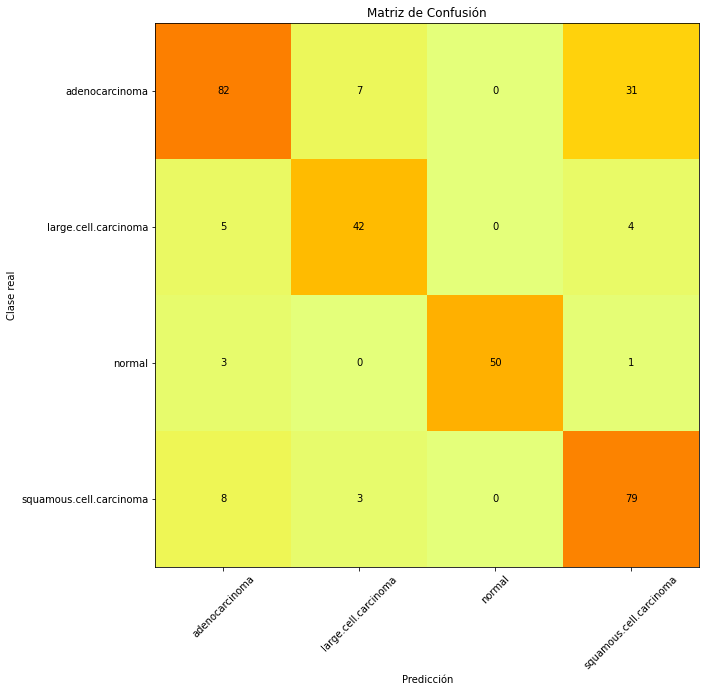

In [ ]:
plot_confusionMatrix(Y_test,y_predicted,class_names)